In [27]:
import os
os.sys.path.append('../Models/')
import tfanfis
# import membership.mfDerivs
# import membership.membershipfunction
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Epoch 1/50
5/5 [==============================] - 6s 248ms/step - loss: 0.2288 - val_loss: 0.2470
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2261 - val_loss: 0.2433
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2233 - val_loss: 0.2403
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2208 - val_loss: 0.2374
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2185 - val_loss: 0.2346
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2162 - val_loss: 0.2320
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2141 - val_loss: 0.2294
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.2118 - val_loss: 0.2270
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 0.2098 - val_loss: 0.2246
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2077 - val_loss: 0.2224
Epoch 11/50
5/5 [===========

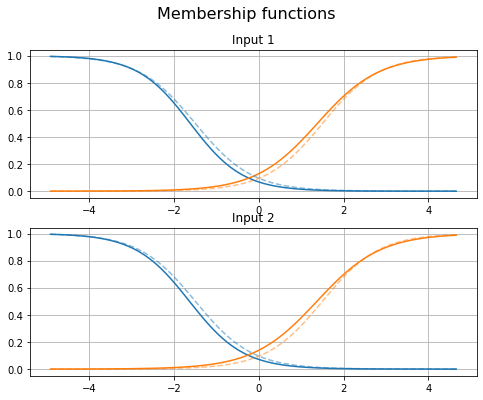

Model: "tfanfis"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLayer (InputLayer)        [(32, 2)]            0           []                               
                                                                                                  
 fuzzyLayer (FuzzyLayer)        (32, 2, 2)           8           ['inputLayer[0][0]']             
                                                                                                  
 ruleLayer (RuleLayer)          (32, 4)              0           ['fuzzyLayer[0][0]']             
                                                                                                  
 normLayer (NormLayer)          (32, 4)              0           ['ruleLayer[0][0]']              
                                                                                            

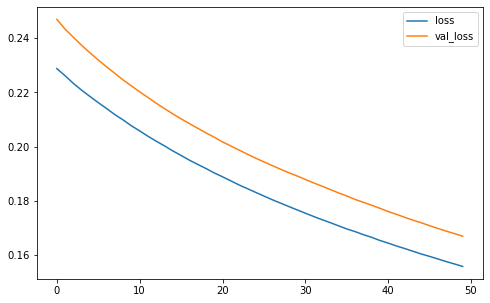

In [22]:
param = tfanfis.fis_parameters(
    n_input = 2,                # no. of Regressors
    n_memb = 2,                 # no. of fuzzy memberships
    batch_size = 32,            # 16 / 32 / 64 / ...
    memb_func = 'sigmoid',      # 'gaussian' / 'gbellmf' / 'sigmoid'
    optimizer = 'adam',          # sgd / adam / ...
    loss = 'huber_loss',               # mse / mae / huber_loss / mean_absolute_percentage_error / ...
    n_epochs = 50               # 10 / 25 / 50 / 100 / ...
)
# create random data
X_train = np.random.rand(param.batch_size*5, param.n_input)
X_test = np.random.rand(param.batch_size*2, param.n_input)
y_train = np.random.rand(param.batch_size*5,1)
y_test = np.random.rand(param.batch_size*2, 1)

fis = tfanfis.ANFIS(
    n_input = param.n_input,
    n_memb = param.n_memb,
    batch_size = param.batch_size,
    memb_func = param.memb_func,
    name = 'tfanfis'
)

# compile model
fis.model.compile(
    optimizer=param.optimizer,
    loss=param.loss
    #,metrics=['mse']  # ['mae', 'mse']
)

# fit model
history = fis.fit(
    X_train, y_train,
    epochs=param.n_epochs,
    batch_size=param.batch_size,
    validation_data = (X_test, y_test),
    # callbacks = [tensorboard_callback]  # for tensorboard
)

# eval model
import pandas as pd
fis.plotmfs(show_initial_weights=True)

loss_curves = pd.DataFrame(history.history)
loss_curves.plot(figsize=(8, 5))

fis.model.summary()

# get premise parameters
premise_parameters = fis.model.get_layer('fuzzyLayer').get_weights()       # alternative

# get consequence paramters
bias = fis.bias
weights = fis.weights
# conseq_parameters = fis.model.get_layer('defuzzLayer').get_weights()       # alternative


In [3]:
# fis.model.__dict__

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((80, 2), (80, 1), (32, 2), (32, 1))

In [35]:
trainpredict = fis.model.predict(
    X_train
)
testpredict = fis.model.predict(
    X_test
)

# fis(X_test)
def mape(actual, forecast):
    # https://www.forecastpro.com/2020/08/24/how-do-i-measure-forecast-accuracy/
    # MAPE (Mean Absolute Percent Error)
    # 1/n sum((actual-forecast)/actual) * 100
    return (1/len(actual) * sum((actual-forecast)/actual)) * 100

def mapeAccuracy(testy, testpredict):
    err = abs(mape(testy, testpredict))
    return {
        'acc': abs(100-err),
        'err': err
    }


mapeAccuracy(y_test.flatten(), testpredict.flatten())
# mape(np.array([1,2,3]),np.array([2,2,3]))
# testy, testpredict

{'acc': 4.455257206210007, 'err': 104.45525720621}

(160, 1)
(64, 1)
(224,)
(224,)


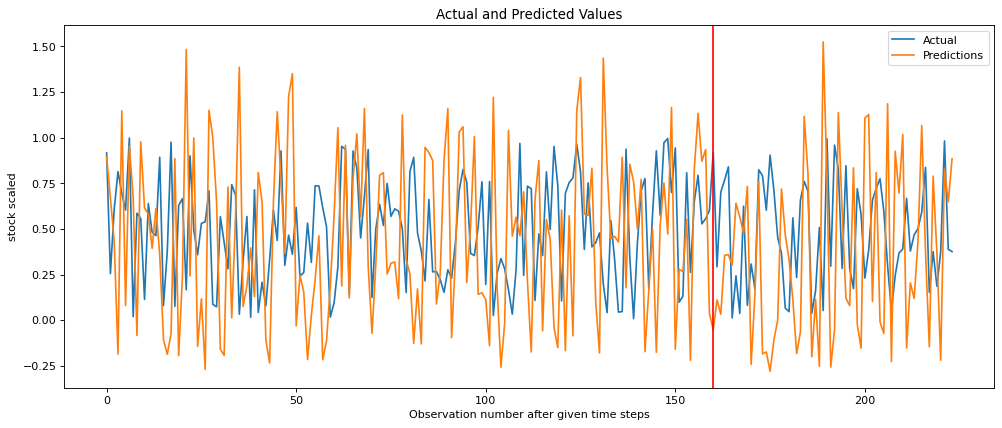

In [30]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    print(trainY.shape)
    print(testY.shape)
    print(actual.shape)
    print(predictions.shape)
    
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('stock scaled')
    plt.title('Actual and Predicted Values')

plot_result(y_train, y_test, trainpredict, testpredict)